In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import pandas as pd
import pandas as pd
from matplotlib import pyplot as plt
import fiona
import rasterio
import rasterio.plot
import matplotlib as mpl
from descartes import PolygonPatch
import numpy as np
import os
from rasterio import plot
from rasterio.plot import show

In [2]:
# Works with the kernel myenv_adi_2
import pandas as pd
import numpy as np


#Works with kernel Blanca, working on including it in myenv_adi 2

# The data preprossing part can be completed using myenv_adi_2, while the Machine learning part
# which runs as a post processing technique uses skikit-learn, which is present in Blanca
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [8]:
# Comment out the code given below to create the file WinterWheat_tagged.pkl, which will be 
# used for training the Machine learning models for WinterWheat
import scripts.data_prep as data_prep

# Input the file paths here

raster_path = "/application/pi/Desktop/all imp data/k19-08031.tif"
vector_path = "/application/pi/Desktop/adi_budnip/WinterWheat.shp"

# # Make the data file from the Raster and shape file with necessary preprocessing
# data = data_prep.make_dataframe_with_bands(vector_path,raster_path)

# Make 512x512 images from original image and get a single dataframe with n images
data_split_image,data_split_mask  = data_prep.trainingDataForUNET(vector_path,raster_path)

# #data = pd.to_pickle('WinterWheat_tagged.pkl')

/application/pi/anaconda3/envs/env_adi_2/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


EPSG:32632


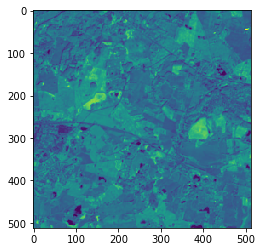

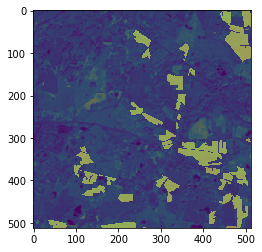

In [9]:
plt.imshow(data_split_image[6][5])
plt.imshow(data_split_mask[6], alpha = 0.0)
plt.show()

plt.imshow(data_split_image[6][5])
plt.imshow(data_split_mask[6], alpha = 0.5)
plt.show()



In [10]:
data_split_image.shape

(20, 12, 512, 512)

In [11]:
# creating all images

for i in range(20):
    image = data_split_image[i]
    img_str = 'image_'+str(i)+".npy"
    np.save('/application/pi/Desktop/all imp data/Unet_training/images/k19-08031'+img_str, image)
    
    mask = data_split_mask[i]
    np.save('/application/pi/Desktop/all imp data/Unet_training/masks/k19-08031'+img_str, mask)
    

# Logistic regression starts below

In [4]:
# Getting the preprocessed data as 12 bands and masked with arow "isWheat" which is Binary
# , 1 indicating that wheat is present
data = pd.read_pickle('/application/pi/Desktop/all imp data/WinterWheat_tagged.pkl')

In [5]:
# Collecting predictions as y
y = data['isWheat']
del(data['isWheat'])

# Normalizing the data
data=(data-data.mean())/data.std()

In [6]:
# Visualizing the data
data

,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,NDVI
0,0.154516,0.301708,0.187339,0.572528,0.126428,-1.250040,-1.157661,-0.984016,-1.145847,-0.827716,0.102419,0.402274,-0.058890
1,0.154516,0.237324,0.096026,0.499544,-0.139234,-0.635227,-0.613669,-0.966480,-0.570336,-0.827716,0.238127,0.300531,-0.056731
2,0.154516,-0.256290,-0.350758,-0.168365,-0.139234,-0.635227,-0.613669,-0.444789,-0.570336,-0.827716,0.238127,0.300531,-0.029524
3,0.127992,-0.349289,-0.269228,-0.763290,-0.345596,0.639115,0.746900,0.719151,0.724850,-0.366717,1.003520,0.454105,-0.003094
4,0.127992,-0.113213,-0.190960,-0.539917,-0.345596,0.639115,0.746900,0.982189,0.724850,-0.366717,1.003520,0.454105,-0.006672
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6352572,-0.482071,-0.621135,-0.807326,-0.124132,-0.682417,-1.772233,-1.617059,-1.505706,-1.555455,-1.655215,-0.094810,0.473301,-0.054875
6352573,-0.582864,-0.528135,-0.735580,-0.121921,-0.708508,-1.749876,-1.633508,-1.501322,-1.560031,-1.766315,-0.065859,0.502096,-0.054801
6352574,-0.582864,-0.599673,-0.758408,-0.175000,-0.708508,-1.749876,-1.633508,-1.549546,-1.560031,-1.766315,-0.065859,0.502096,-0.054654
6352575,-0.582864,-0.549596,-0.774714,-0.155095,-0.696648,-1.775427,-1.625283,-1.575850,-1.572617,-1.766315,-0.121952,0.500176,-0.056259


In [5]:
# Creating indices for every band(X and Y) using the formula (Band_X-Band_Y)/(Band_X+Band_y)

for i in range(1,13):
    for j in range(1,13):
        if i>j:
            BA = 'B'+str(i)
            BB = 'B'+str(j)
            B_net = BA + BB
            data[B_net] =(data[BA]-data[BB])/(data[BB]+data[BA]) 


# Storing training values
X = data
del(data)
X
# Splitting data into train test
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

# Training Logistic Regression classifier
logisticRegr = LogisticRegression(max_iter=100)
logisticRegr.fit(x_train, y_train)

/application/pi/anaconda3/envs/Blanca/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [6]:
# Predictin the model on test
predictions = logisticRegr.predict(x_test)

In [7]:
# Accuracy

score = logisticRegr.score(x_test, y_test)
print(score*100,'%')

74.07944488695931 %


In [8]:
# Get Accuracy considering only wheat fields

cm = metrics.confusion_matrix(y_test, predictions)
print ('% of area detected right = ', cm[1][1]/(cm[1][1]+cm[1][0])*100," %")

% of area detected right =  87.64458116029749  %
